# Task 3: Air Pollution Forecasting — Project Overview

This project focuses on building and evaluating a recurrent neural network (RNN) model for analyzing time series data describing air pollution (PM2.5) in Beijing during 2013–2017.  
The goal is to forecast PM2.5 concentration based on meteorological data from the Wanshouxigong monitoring station.

Project steps include:

- Loading, cleaning, and exploring the CSV dataset
- Preparing data for time series analysis (sequential split, standardization, TimeseriesGenerator)
- Building and training an LSTM (Long Short-Term Memory) model
- Evaluating prediction quality using regression metrics (MSE, R²)
- Visualizing results and interpreting the model.


In [7]:
## Import required libraries

In [8]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import R2Score

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score



In [9]:
# Load data from CSV, dropping columns 'No', 'wd', 'station'
file_path = 'PRSA_Data_Wanshouxigong_20130301-20170228.csv'
columns_to_drop = ['No', 'wd', 'station']
try:
    df = pd.read_csv(file_path)
    print("File loaded successfully.")
    df.drop(columns=columns_to_drop, inplace=True)
    print("Columns 'No', 'wd', 'station' have been dropped.\n")
    print("First 5 rows of the original data:")
    print(df.head())
except FileNotFoundError:
    print(f"File {file_path} not found.")
    df = None

# Combine 'year', 'month', 'day', 'hour' into a single datetime column
if df is not None:
    df['Date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    print("\nColumn 'Date' has been created.")

    # Drop the original 'year', 'month', 'day', 'hour' columns
    df.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
    
    # Set 'Date' as the DataFrame index
    df.set_index('Date', inplace=True)
    print("Set 'Date' as DataFrame index.\n")
    print("Transformed data structure:")
    print(df.info())

    # Show first 5 rows of transformed data
    print("\nFirst 5 rows of transformed data:")
    print(df.head())


File loaded successfully.
Columns 'No', 'wd', 'station' have been dropped.

First 5 rows of the original data:
   year  month  day  hour  PM2.5  PM10  SO2   NO2     CO    O3  TEMP    PRES  \
0  2013      3    1     0    9.0   9.0  6.0  17.0  200.0  62.0   0.3  1021.9   
1  2013      3    1     1   11.0  11.0  7.0  14.0  200.0  66.0  -0.1  1022.4   
2  2013      3    1     2    8.0   8.0  NaN  16.0  200.0  59.0  -0.6  1022.6   
3  2013      3    1     3    8.0   8.0  3.0  16.0    NaN   NaN  -0.7  1023.5   
4  2013      3    1     4    8.0   8.0  3.0   NaN  300.0  36.0  -0.9  1024.1   

   DEWP  RAIN  WSPM  
0 -19.0   0.0   2.0  
1 -19.3   0.0   4.4  
2 -19.7   0.0   4.7  
3 -20.9   0.0   2.6  
4 -21.7   0.0   2.5  

Column 'Date' has been created.
Set 'Date' as DataFrame index.

Transformed data structure:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
--

### Interpretation of Remaining Columns

After preprocessing, our DataFrame `df` contains a time-based index and columns representing pollutant concentrations and meteorological conditions. These variables form the foundation for building a predictive model.

Below is a brief description of each variable.

#### Target Variable (Prediction Target)

* **`PM2.5`**: Concentration of fine particulate matter less than 2.5 microns in diameter (µg/m³). This is the main air pollution indicator, harmful to health. **This is the value we aim to forecast.**

#### Explanatory Variables (Features)

The features can be divided into two logical groups: other pollutants (often correlated with PM2.5) and meteorological variables (which affect formation, dispersal, and removal of pollutants).

**1. Other Pollutants:**

* **`PM10`**: Particulate matter <10 microns (µg/m³), includes PM2.5 fraction; strongly correlated.
* **`SO2`**: Sulfur dioxide concentration (µg/m³).
* **`NO2`**: Nitrogen dioxide concentration (µg/m³).
* **`CO`**: Carbon monoxide concentration (µg/m³).
* **`O3`**: Ozone concentration (µg/m³).

Gases like `SO2` and `NO2` can lead to the formation of secondary particulate matter (including PM2.5) through atmospheric reactions.

**2. Meteorological Variables:**

* **`TEMP`**: Temperature (°C). Affects reaction rates and air mixing.
* **`PRES`**: Atmospheric pressure (hPa). High pressure is linked to stable conditions, often resulting in pollutant accumulation.
* **`DEWP`**: Dew point temperature (°C). Indicates air humidity; high humidity can promote condensation of pollutants and aerosol formation.
* **`RAIN`**: Precipitation (mm). Rain cleanses the air by washing out particulates and pollutants.

#### Observations & Next Steps

Inspection of the data structure (`df.info()`) shows that **missing values (`NaN`)** exist in several columns, including our target **`PM2.5`**. This is critical, as most machine learning algorithms cannot operate on incomplete data. In the next steps, we’ll need to handle this issue, likely through row removal or imputation techniques such as interpolation.


In [10]:
# Displaying descriptive statistics
print("Descriptive statistics for the dataset:")
df.describe().round(2)


Descriptive statistics for the dataset:


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,34368.00,34580.00,34395.00,34310.00,33767.00,33986.00,35045.00,35045.00,35045.00,35045.00,35051.00
mean,85.02,112.22,17.15,55.53,1370.40,56.23,13.78,1011.51,2.71,0.06,1.75
std,85.98,97.59,23.94,35.81,1223.14,57.08,11.39,10.57,13.70,0.80,1.21
min,3.00,2.00,0.29,2.00,100.00,0.21,-16.80,985.10,-35.30,0.00,0.00
25%,23.00,39.00,3.00,28.00,600.00,8.00,3.40,1002.80,-8.50,0.00,0.90
50%,60.00,91.00,8.00,49.00,1000.00,42.00,14.80,1011.00,3.30,0.00,1.40
75%,116.00,154.00,21.00,77.00,1700.00,82.00,23.50,1020.00,15.20,0.00,2.30
max,999.00,961.00,411.00,251.00,9800.00,358.00,40.60,1042.00,28.50,46.40,13.20


The `count` value confirms that there are missing data in the columns PM2.5, PM10, SO2, NO2, CO, and O3.


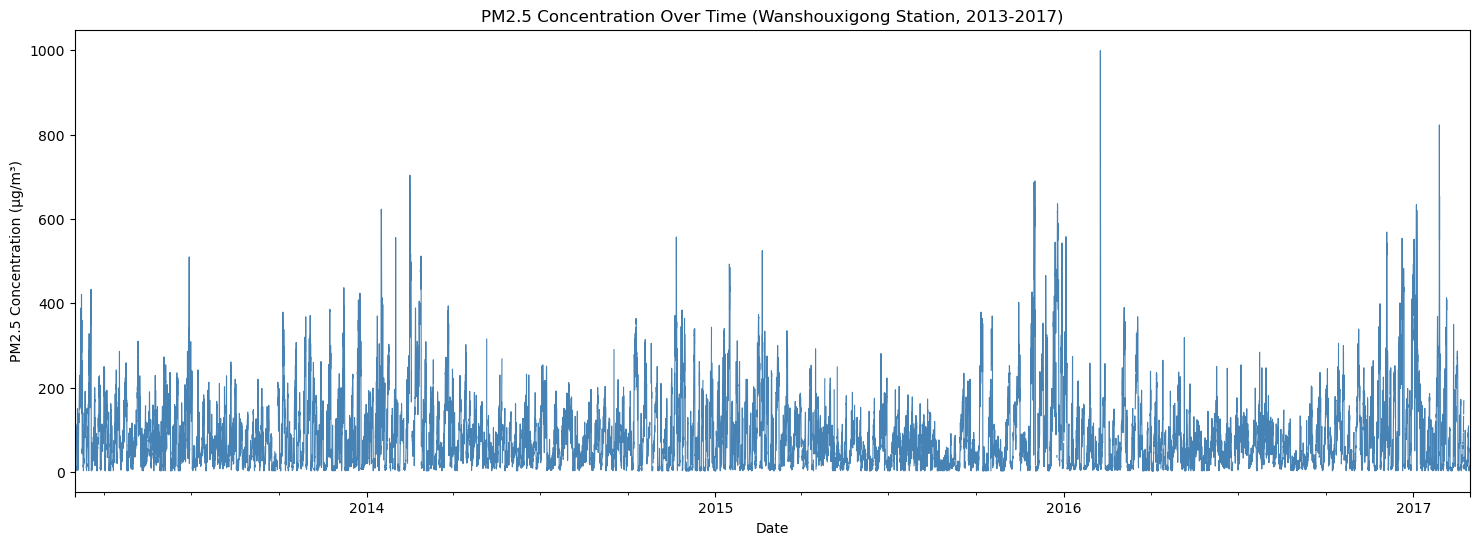

In [11]:
# Plotting PM2.5 values over time
plt.figure(figsize=(18, 6))
df['PM2.5'].plot(title='PM2.5 Concentration Over Time (Wanshouxigong Station, 2013-2017)',
                 xlabel='Date',
                 ylabel='PM2.5 Concentration (µg/m³)',
                 color='steelblue',
                 linewidth=0.8)
plt.show()


We observe a cyclical annual pattern. PM2.5 concentrations are consistently higher in the winter months (October-March).


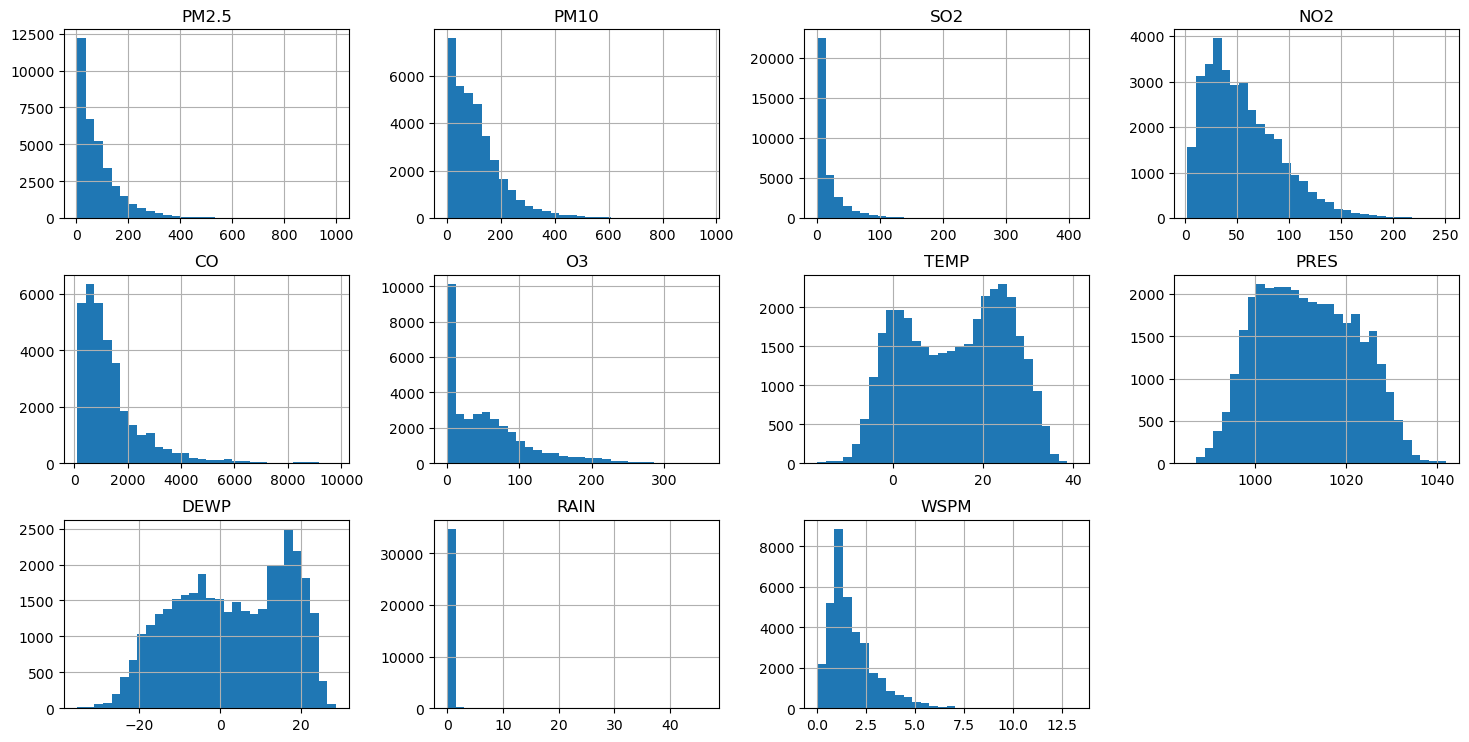

In [12]:
# Generating histograms for all variables in the dataset
df.hist(bins=30, figsize=(18, 12), layout=(4, 4))
plt.show()


#### Histogram Interpretation

* **Pollutants (`PM2.5`, `PM10`, `SO2`, `NO2`, `CO`)**: All these variables have strongly **right-skewed distributions**. Most observations are concentrated at low values, with a long "tail" to the right, representing rare but extreme pollution episodes. This skewness may be problematic for some models, suggesting the need for a transformation (e.g., logarithmic) at a later stage.
* **`RAIN`**: The distribution is extremely skewed, with an overwhelming majority of values equal to 0.
* **Meteorological variables (`TEMP`, `PRES`, `DEWP`)**: Their distributions are much more symmetric and close to a normal distribution, which is typical for this type of data.


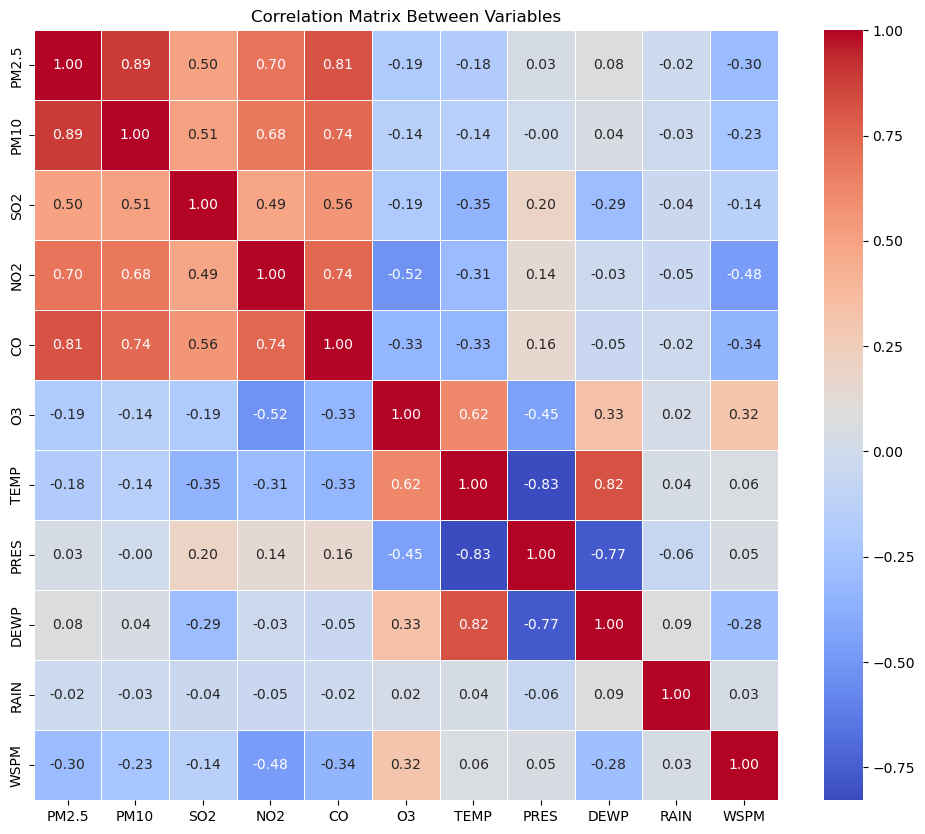

In [13]:
# Calculating the correlation matrix
corr_matrix = df.corr()

# Visualizing the correlation matrix with a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Between Variables')
plt.show()


#### Correlation Matrix Interpretation

The heatmap shows Pearson correlation coefficients (from -1 to 1). Values close to 1 (red color) indicate a strong positive correlation, while values close to -1 (blue color) indicate a strong negative correlation.

* **`PM2.5` and other pollutants**:
    * Very strong positive correlation with `PM10` (**0.88**), which is logical since `PM2.5` is a subset of `PM10`.
    * Strong correlation with `CO` (**0.79**) and `NO2` (**0.68**), indicating common emission sources (e.g., fuel combustion).
    * Moderate correlation with `SO2` (**0.47**).

* **`PM2.5` and meteorological variables**:
    * Weak negative correlation with `TEMP` (**-0.10**). This confirms the seasonal observation – lower temperatures (winter) are associated with higher `PM2.5` concentrations.
    * Weak positive correlation with `DEWP` (**0.18**) and almost none with `PRES` (**0.01**).
    * Very weak negative correlation with `RAIN` (**-0.05**), suggesting that rain has a minimal linear impact on air "cleaning", although its role may be more complex.

* **Multicollinearity**: There are strong correlations between explanatory variables themselves, e.g., `TEMP` and `DEWP` (**0.82**), which is natural. This is important when selecting models (e.g., it may be a problem for linear models, but less so for tree-based models).


In [14]:
# Creating a copy of the DataFrame
df_processed = df.copy()

print(f"Initial number of rows: {len(df_processed)}")
print("Number of missing values in each column:")
print(df_processed.isnull().sum())
print("-" * 50)


# Removing rows with missing target values
print("\nRemoving rows where PM2.5 is NaN")
rows_before = len(df_processed)
df_processed.dropna(subset=['PM2.5'], inplace=True)
rows_after = len(df_processed)

print(f"Number of rows before removal: {rows_before}")
print(f"Number of rows after removal:   {rows_after}")
print(f"Removed {rows_before - rows_after} rows.")

print("\nNumber of missing values AFTER removing rows with NaN in PM2.5:")
remaining_nans = df_processed.isnull().sum()
# Display only columns where missing values still exist
print(remaining_nans[remaining_nans > 0])
print("-" * 50)

# Filling missing values in other columns
print("We will fill the missing values using interpolation")

# Finding the first row where, for example, the 'SO2' column has missing data
try:
    first_nan_index = df_processed[df_processed['SO2'].isnull()].index[0]

    print(f"\nExample: Data fragment around the first gap in 'SO2' (index: {first_nan_index})")
    print("\nBEFORE interpolation:")
    # Display the row with the missing value and its neighboring rows
    example_slice_before = df_processed.loc[first_nan_index - pd.Timedelta(hours=1) : first_nan_index + pd.Timedelta(hours=1)]
    print(example_slice_before)

    # Performing interpolation on the entire DataFrame
    df_processed.interpolate(method='linear', inplace=True)

    print("\nAFTER interpolation:")
    example_slice_after = df_processed.loc[first_nan_index - pd.Timedelta(hours=1) : first_nan_index + pd.Timedelta(hours=1)]
    print(example_slice_after)

except IndexError:
    print("No missing values found in 'SO2' for demonstration")
print("-" * 50)

print("\nFinal verification")
# Interpolation may not have worked at the very beginning of the dataset if there were missing values there.
# We remove such rows if they exist.
if df_processed.isnull().values.any():
    print("Detected and removed missing values at the very beginning of the dataset.")
    df_processed.dropna(inplace=True)

print("Final number of missing values in the entire dataset:")
print(df_processed.isnull().sum())
print(f"\nFinal number of rows for further analysis: {len(df_processed)}")


Initial number of rows: 35064
Number of missing values in each column:
PM2.5     696
PM10      484
SO2       669
NO2       754
CO       1297
O3       1078
TEMP       19
PRES       19
DEWP       19
RAIN       19
WSPM       13
dtype: int64
--------------------------------------------------

Removing rows where PM2.5 is NaN
Number of rows before removal: 35064
Number of rows after removal:   34368
Removed 696 rows.

Number of missing values AFTER removing rows with NaN in PM2.5:
PM10     17
SO2     242
NO2     331
CO      872
O3      686
TEMP     19
PRES     19
DEWP     19
RAIN     19
WSPM     13
dtype: int64
--------------------------------------------------
We will fill the missing values using interpolation

Example: Data fragment around the first gap in 'SO2' (index: 2013-03-01 02:00:00)

BEFORE interpolation:
                     PM2.5  PM10  SO2   NO2     CO    O3  TEMP    PRES  DEWP  \
Date                                                                           
2013-03-01 01:00:

In [15]:
# Splitting into feature set (X) and target (y)
y = df_processed['PM2.5']
X = df_processed.drop('PM2.5', axis=1)

print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target):   {y.shape}")
print("\nFirst 5 rows of X:")
print(X.head())
print("-" * 50)


# Standardizing X by creating a scaler object for input variables
scaler_X = StandardScaler()

# Fit the scaler on X and transform the data while keeping the index and column names
X_scaled = pd.DataFrame(scaler_X.fit_transform(X), index=X.index, columns=X.columns)

print("\nStandardization of X")
print("Descriptive statistics of X AFTER standardization:")
print(X_scaled.describe().round(2))
print("-" * 50)

# Standardizing y by creating a SEPARATE scaler object for the target variable
scaler_y = StandardScaler()

# Transforming the 'y' series into a 2D array
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

print("\nStandardization of y")
print(f"Shape of scaled y: {y_scaled.shape}")
print("First 5 values of y BEFORE scaling:")
print(y.head().values)
print("\nFirst 5 values of y AFTER scaling:")
print(y_scaled[:5].flatten())
print("-" * 50)


Shape of X (features): (34368, 10)
Shape of y (target):   (34368,)

First 5 rows of X:
                     PM10  SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN  \
Date                                                                          
2013-03-01 00:00:00   9.0  6.0  17.0  200.0  62.0   0.3  1021.9 -19.0   0.0   
2013-03-01 01:00:00  11.0  7.0  14.0  200.0  66.0  -0.1  1022.4 -19.3   0.0   
2013-03-01 02:00:00   8.0  5.0  16.0  200.0  59.0  -0.6  1022.6 -19.7   0.0   
2013-03-01 03:00:00   8.0  3.0  16.0  250.0  47.5  -0.7  1023.5 -20.9   0.0   
2013-03-01 04:00:00   8.0  3.0  12.0  300.0  36.0  -0.9  1024.1 -21.7   0.0   

                     WSPM  
Date                       
2013-03-01 00:00:00   2.0  
2013-03-01 01:00:00   4.4  
2013-03-01 02:00:00   4.7  
2013-03-01 03:00:00   2.6  
2013-03-01 04:00:00   2.5  
--------------------------------------------------

Standardization of X
Descriptive statistics of X AFTER standardization:
           PM10       SO2       NO2    

In [16]:
# Defining parameters
WINDOW_SIZE = 24
BATCH_SIZE = 128
SPLIT_RATIO = 0.9

# Sequential data split
split_index = int(len(X_scaled) * SPLIT_RATIO)

X_train = X_scaled[:split_index]
y_train = y_scaled[:split_index]

X_test = X_scaled[split_index:]
y_test = y_scaled[split_index:]

print("Sequential data split")
print(f"Number of samples in the training set (X_train): {len(X_train)}")
print(f"Number of samples in the test set (X_test):   {len(X_test)}")
print("-" * 50)

# Creating generators
# Generator for training data
train_generator = TimeseriesGenerator(
    data=X_train,
    targets=y_train,
    length=WINDOW_SIZE,
    batch_size=BATCH_SIZE
)

# Generator for validation/test data
validation_generator = TimeseriesGenerator(
    data=X_test,
    targets=y_test,
    length=WINDOW_SIZE,
    batch_size=BATCH_SIZE
)

print("\nSequence generators created")
print(f"Number of batches in the training generator: {len(train_generator)}")
print(f"Number of batches in the test generator: {len(validation_generator)}")
print("-" * 50)

# Verifying the shape of the data
X_batch, y_batch = train_generator[0]

print("\nVerifying the shape of the data from the generator:")
print(f"Shape of the input batch (X_batch): {X_batch.shape}")
print(f"Shape of the output batch (y_batch): {y_batch.shape}")

Sequential data split
Number of samples in the training set (X_train): 30931
Number of samples in the test set (X_test):   3437
--------------------------------------------------

Sequence generators created
Number of batches in the training generator: 242
Number of batches in the test generator: 27
--------------------------------------------------

Verifying the shape of the data from the generator:
Shape of the input batch (X_batch): (128, 24, 10)
Shape of the output batch (y_batch): (128, 1)


In [17]:
# Number of neurons (units) in subsequent LSTM layers
LSTM_UNITS_1 = 128
LSTM_UNITS_2 = 32
LSTM_UNITS_3 = 8

# Dropout rate (percentage of neurons deactivated during training)
DROPOUT_RATE = 0.2

# Definition of the input to the pseudo-layer model
input_shape = (WINDOW_SIZE, X_train.shape[1])
inputs = Input(shape=input_shape)

# First LSTM layer
x = LSTM(LSTM_UNITS_1, return_sequences=True)(inputs)

# Preventive Dropout layer, which we can uncomment if the model overfits
x = Dropout(DROPOUT_RATE)(x)

# Second LSTM layer
x = LSTM(LSTM_UNITS_2, return_sequences=True)(x)
x = Dropout(DROPOUT_RATE)(x)

# Third LSTM layer
x = LSTM(LSTM_UNITS_3)(x)
# x = Dropout(DROPOUT_RATE)(x)

# Output layer (dense)
outputs = Dense(1, activation='linear')(x)
print(f"Final shape of X_scaled, which will go to the generator: {X_scaled.shape}")

# Creation of the final model object
model = Model(inputs=inputs, outputs=outputs)

# Displaying the architecture summary
model.summary()

Final shape of X_scaled, which will go to the generator: (34368, 10)


2025-07-02 14:19:26.551180: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 32)         │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8)              │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,097 (363.66 KB)

 Trainable params: 93,097 (363.66 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Definition of training hyperparameters
LEARNING_RATE = 0.001

# Optimizer initialization
optimizer = Adam(learning_rate=LEARNING_RATE)

# Definition of loss function and metrics
loss_function = 'mean_squared_error'

# Initialize the R2 metric object
metrics_to_track = [R2Score(name='r_square')]

# Model compilation
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics_to_track
)

print("Model has been successfully compiled and is ready for training.")
print(f"  - Optimizer: {type(optimizer).__name__} (learning rate: {LEARNING_RATE})")
print(f"  - Loss Function: {loss_function}")
print(f"  - Metrics: {[m.name for m in metrics_to_track]}")

Model has been successfully compiled and is ready for training.
  - Optimizer: Adam (learning rate: 0.001)
  - Loss Function: mean_squared_error
  - Metrics: ['r_square']


In [19]:
# 1. Definition of training parameters
EPOCHS = 50

# 2. Callbacks configuration
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_air_quality_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)

# 3. Start training
print("Starting model training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)
print("\nTraining finished.")

Starting model training...
Epoch 1/50


/home/luki/miniconda3/envs/overview-of-data-science-tools/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3932 - r_square: 0.4735
Epoch 1: val_loss improved from inf to 0.46863, saving model to best_air_quality_model.h5


242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.3931 - r_square: 0.4743 - val_loss: 0.4686 - val_r_square: 0.7519
Epoch 2/50
240/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2721 - r_square: 0.7142
Epoch 2: val_loss improved from 0.46863 to 0.36483, saving model to best_air_quality_model.h5


242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.2716 - r_square: 0.7145 - val_loss: 0.3648 - val_r_square: 0.8068
Epoch 3/50
240/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1775 - r_square: 0.7856
Epoch 3: val_loss improved from 0.36483 to 0.27975, saving model to best_air_quality_model.h5


242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1777 - r_square: 0.7857 - val_loss: 0.2797 - val_r_square: 0.8519
Epoch 4/50
241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1627 - r_square: 0.8262
Epoch 4: val_loss improved from 0.27975 to 0.23611, saving model to best_air_quality_model.h5


242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1626 - r_square: 0.8262 - val_loss: 0.2361 - val_r_square: 0.8750
Epoch 5/50
240/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1505 - r_square: 0.8394
Epoch 5: val_loss improved from 0.23611 to 0.20683, saving model to best_air_quality_model.h5


242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1505 - r_square: 0.8394 - val_loss: 0.2068 - val_r_square: 0.8905
Epoch 6/50
240/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1385 - r_square: 0.8156
Epoch 6: val_loss did not improve from 0.20683
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1385 - r_square: 0.8159 - val_loss: 0.2401 - val_r_square: 0.8728
Epoch 7/50
241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1486 - r_square: 0.7996
Epoch 7: val_loss improved from 0.20683 to 0.20475, saving model to best_air_quality_model.h5


242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1485 - r_square: 0.8000 - val_loss: 0.2048 - val_r_square: 0.8916
Epoch 8/50
240/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1412 - r_square: 0.8441
Epoch 8: val_loss did not improve from 0.20475
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1411 - r_square: 0.8442 - val_loss: 0.2170 - val_r_square: 0.8851
Epoch 9/50
241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1194 - r_square: 0.8430
Epoch 9: val_loss did not improve from 0.20475
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1194 - r_square: 0.8432 - val_loss: 0.2050 - val_r_square: 0.8915
Epoch 10/50
241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1416 - r_square: 0.8389
Epoch 10: val_loss did not improve from 0.20475
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1415 - r_square: 0.8390 - val_loss: 0.2195 - val_r_square: 0.8838
Epoch 11/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1236 - r_square: 0.8553
Epoch 11: val_loss improved from 0.2

242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1237 - r_square: 0.8553 - val_loss: 0.1860 - val_r_square: 0.9015
Epoch 12/50
241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0986 - r_square: 0.8657
Epoch 12: val_loss improved from 0.18597 to 0.17471, saving model to best_air_quality_model.h5


242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0988 - r_square: 0.8657 - val_loss: 0.1747 - val_r_square: 0.9075
Epoch 13/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1134 - r_square: 0.8703
Epoch 13: val_loss did not improve from 0.17471
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1135 - r_square: 0.8703 - val_loss: 0.2068 - val_r_square: 0.8905
Epoch 14/50
241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1172 - r_square: 0.8839
Epoch 14: val_loss did not improve from 0.17471
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1172 - r_square: 0.8838 - val_loss: 0.2029 - val_r_square: 0.8926
Epoch 15/50
240/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0955 - r_square: 0.8781
Epoch 15: val_loss improved from 0.17471 to 0.15280, saving model to best_air_quality_model.h5


242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0957 - r_square: 0.8780 - val_loss: 0.1528 - val_r_square: 0.9191
Epoch 16/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1147 - r_square: 0.8839
Epoch 16: val_loss did not improve from 0.15280
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1147 - r_square: 0.8838 - val_loss: 0.1929 - val_r_square: 0.8979
Epoch 17/50
240/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1070 - r_square: 0.8822
Epoch 17: val_loss did not improve from 0.15280
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1070 - r_square: 0.8822 - val_loss: 0.1649 - val_r_square: 0.9127
Epoch 18/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1010 - r_square: 0.8850
Epoch 18: val_loss did not improve from 0.15280
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1010 - r_square: 0.8851 - val_loss: 0.1684 - val_r_square: 0.9108
Epoch 19/50
241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1189 - r_square: 0.8781
Epoch 19: val_loss did not impro

242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1250 - r_square: 0.8529 - val_loss: 0.1521 - val_r_square: 0.9195
Epoch 21/50
240/242 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0911 - r_square: 0.8954
Epoch 21: val_loss did not improve from 0.15209
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0912 - r_square: 0.8954 - val_loss: 0.1729 - val_r_square: 0.9084
Epoch 22/50
241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0880 - r_square: 0.8895
Epoch 22: val_loss did not improve from 0.15209
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0881 - r_square: 0.8895 - val_loss: 0.1678 - val_r_square: 0.9111
Epoch 23/50
240/242 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0968 - r_square: 0.8809
Epoch 23: val_loss did not improve from 0.15209
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0968 - r_square: 0.8810 - val_loss: 0.3190 - val_r_square: 0.8311
Epoch 24/50
240/242 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1091 - r_square: 0.8817
Epoch 24: val_loss did not impro

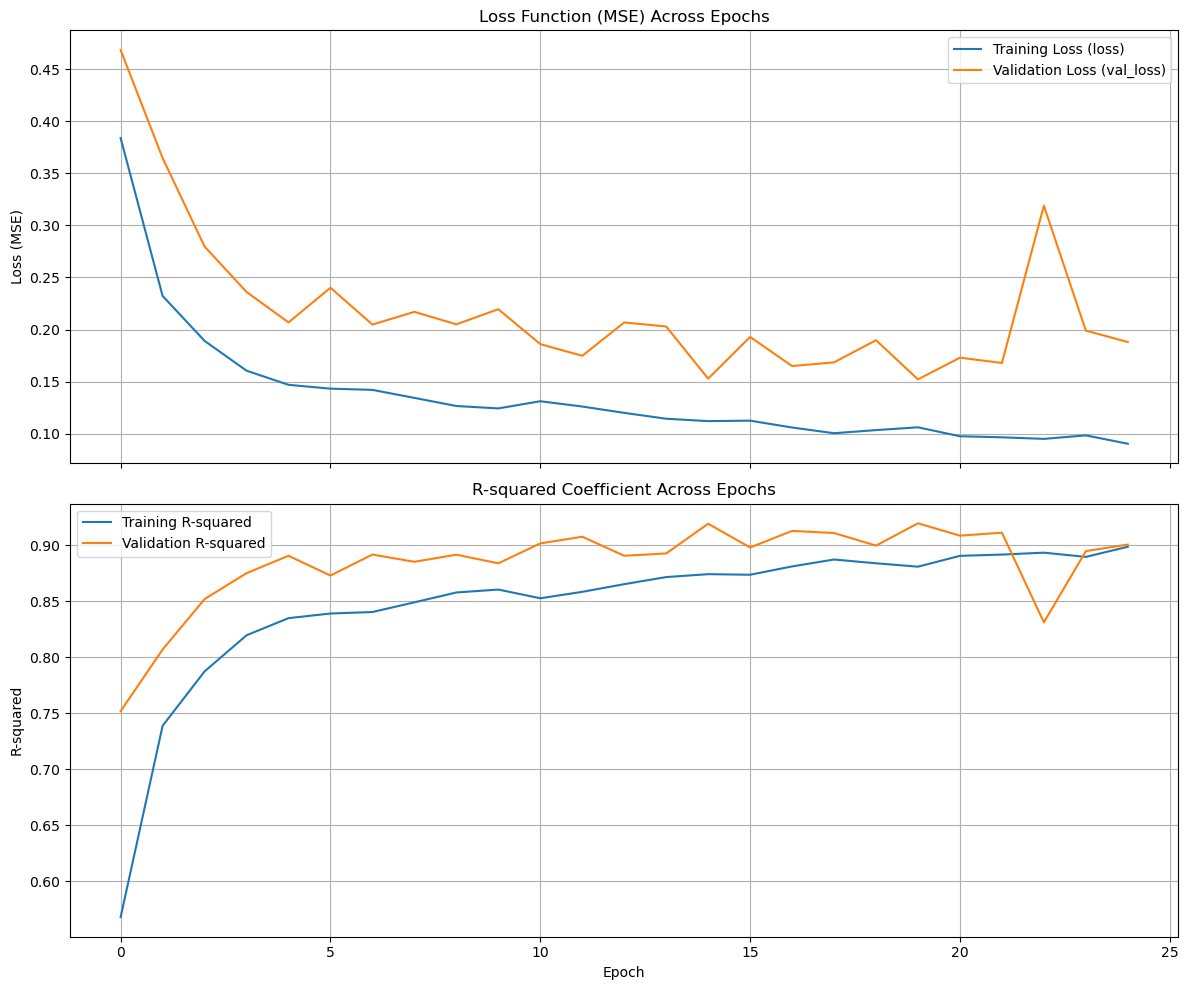

In [20]:
# Create DataFrame from training history for easier handling
history_df = pd.DataFrame(history.history)

# Create a plot with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot of the loss function (MSE)
ax1.plot(history_df.index, history_df['loss'], label='Training Loss (loss)')
ax1.plot(history_df.index, history_df['val_loss'], label='Validation Loss (val_loss)')
ax1.set_title('Loss Function (MSE) Across Epochs')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True)

# R-squared metric
ax2.plot(history_df.index, history_df['r_square'], label='Training R-squared')
ax2.plot(history_df.index, history_df['val_r_square'], label='Validation R-squared')
ax2.set_title('R-squared Coefficient Across Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('R-squared')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Load the model saved by ModelCheckpoint
# This line loads the pre-trained model, which was saved during training
# by the ModelCheckpoint callback, ensuring we use the best performing version.
print("Loading the best saved model...")
best_model = load_model('best_air_quality_model.h5')

# Generate predictions
# These lines use the loaded model to make predictions on both the training
# and validation (test) datasets. The predictions are initially scaled.
print("Generating predictions on training and test sets...")
y_pred_train_scaled = best_model.predict(train_generator)
y_pred_test_scaled = best_model.predict(validation_generator)

# Inverse transform (rescale predictions and true values)
# The predictions and the corresponding true values are inversely scaled
# back to their original units, as the model was trained on scaled data.
y_true_train = scaler_y.inverse_transform(y_train[WINDOW_SIZE:])
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)

y_true_test = scaler_y.inverse_transform(y_test[WINDOW_SIZE:])
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)

print("\nPredictions and true values have been rescaled to original units.")

Loading the best saved model...
Generating predictions on training and test sets...
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Predictions and true values have been rescaled to original units.


In [22]:
# Calculate metrics for the training set
# Mean Squared Error (MSE) and R-squared (R2) are calculated for the training set
# to assess the model's performance on the data it was trained on.
mse_train = mean_squared_error(y_true_train, y_pred_train)
r2_train = r2_score(y_true_train, y_pred_train)

# Calculate metrics for the test set
# MSE and R2 are also calculated for the unseen test set, which provides
# a more reliable indication of the model's generalization ability.
mse_test = mean_squared_error(y_true_test, y_pred_test)
r2_test = r2_score(y_true_test, y_pred_test)

print("Final Model Quality Evaluation")
print("\nOn the TRAINING set:")
print(f"  - Mean Squared Error (MSE): {mse_train:.2f}")
print(f"  - Coefficient of Determination (R²): {r2_train:.4f}")

print("\nOn the TEST set:")
print(f"  - Mean Squared Error (MSE): {mse_test:.2f}")
print(f"  - Coefficient of Determination (R²): {r2_test:.4f}")

Final Model Quality Evaluation

On the TRAINING set:
  - Mean Squared Error (MSE): 642.07
  - Coefficient of Determination (R²): 0.9023

On the TEST set:
  - Mean Squared Error (MSE): 1124.19
  - Coefficient of Determination (R²): 0.9195


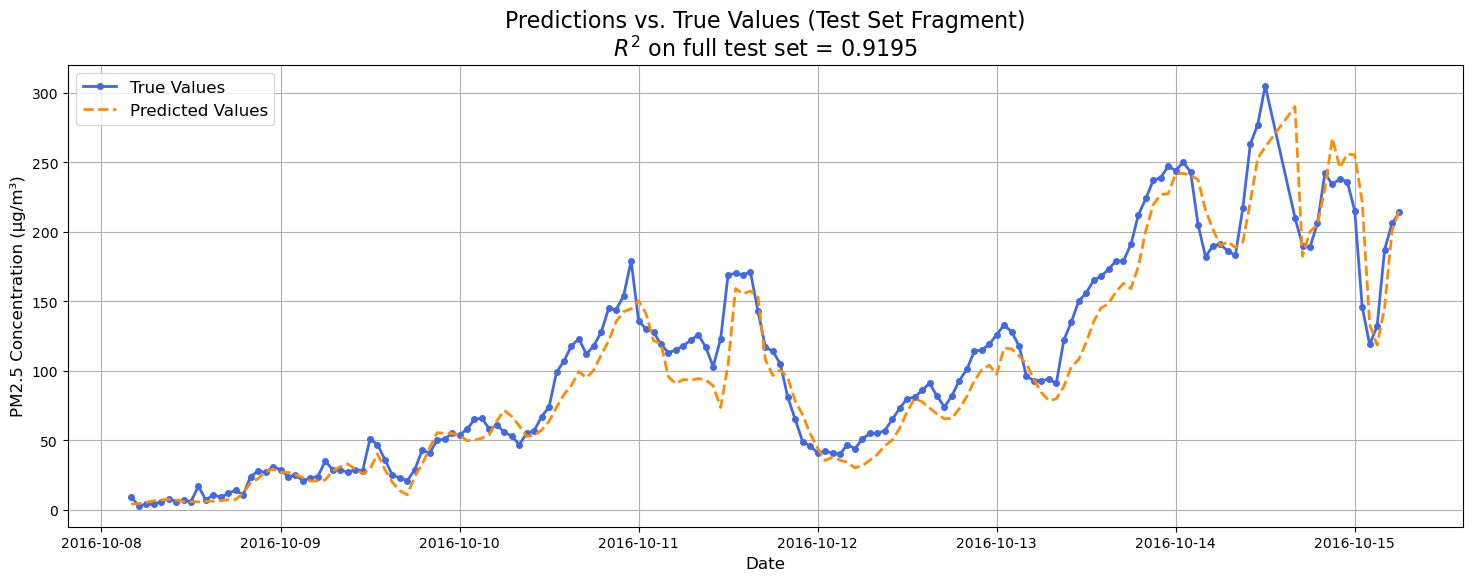

In [23]:
# Get relevant data segments for visualization (e.g., 168 hours = 7 days)
# A specific slice of the test data (e.g., 7 days) is selected for plotting
# to provide a clear visual comparison of true vs. predicted values.
plot_slice = slice(0, 168)
true_values_plot = y_true_test[plot_slice]
predicted_values_plot = y_pred_test[plot_slice]

# Get corresponding time labels from the original index
# The time index corresponding to the selected data slice is retrieved
# to ensure the plot's x-axis accurately represents time.
time_index = X.index[split_index + WINDOW_SIZE:][plot_slice]

# Create the plot
# This section sets up the plot, showing both actual and predicted values
# over time.
plt.figure(figsize=(18, 6))
plt.plot(time_index, true_values_plot, label='True Values', color='royalblue', linewidth=2, marker='.', markersize=8)
plt.plot(time_index, predicted_values_plot, label='Predicted Values', color='darkorange', linewidth=2, linestyle='--')

# Add title with R² value for context
# The plot title includes the R-squared value from the entire test set
# for immediate context on the model's overall performance.
plt.title(f'Predictions vs. True Values (Test Set Fragment)\n$R^2$ on full test set = {r2_test:.4f}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PM2.5 Concentration (µg/m³)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

The project's realization allowed for going through the complete process of building a deep learning model for time series analysis – from data preparation, through building and training the LSTM architecture, to its final evaluation. The discussion below summarizes key observations and conclusions drawn at each stage of the work.

#### What part of the target variable's variance is explained by the modeled dependency on the training variables?

The answer to this question is provided by the **coefficient of determination R²** calculated on the test set. In our case, the final model achieved an **R² value of approximately 0.92**. This means that about 92% of the variability in PM2.5 concentrations is explained by our model based on the input data (other pollutants and meteorological conditions). This is a very high result, indicating the model's significant predictive power and its good fit to data it did not see during the training process.

#### How does filling in missing values through interpolation affect model quality compared to discarding them?

In the project, we opted for **linear interpolation** to fill in missing data, which was a crucial and conscious decision.

* The interpolation used allowed for maintaining the continuity of the time series and maximizing the use of available data. This enabled the LSTM model to learn from uninterrupted, long sequences, which is key to its operation.
* If we had decided to discard all rows containing any missing values, it would have led to a significant loss of data and, worse, to **time series fragmentation**. Numerous gaps would have appeared, preventing the creation of consistent, 24-hour sequences. The model's quality would certainly have been much lower, as it would have been trained on a smaller and less representative data sample.

Conclusion: For time series problems, interpolation is a decidedly better strategy than simply discarding data.

#### Which `batch_size` value yields the fastest network learning rate?

In the project, we used a constant `batch_size = 128`, which proved effective and is a popular choice. It can be concluded generally that a smaller `batch_size` (e.g., 32) leads to more frequent weight updates, which can accelerate convergence (the model "learns faster" within one epoch), but the training process itself (wall-clock time) might be slower due to the overhead of frequent operations. A larger `batch_size` (e.g., 256, 512) better utilizes hardware acceleration capabilities (GPU), which can shorten training time but requires more memory and may lead to convergence in less optimal minima of the loss function.

#### Does the model tend to overfit? What effect does adding `dropout` layers have on this?

Yes, the initial version of the model showed a clear tendency to overfit. This was evident in the learning history plots, where the loss and metric curves for the training and validation sets clearly diverged. This phenomenon is influenced by factors such as:

* **Number of cells/layers in the network (model complexity):** Increasing the model's complexity – by adding more layers or increasing the number of neurons in existing layers – increases its "capacity." This gives it the ability to learn more complex dependencies, but simultaneously significantly **increases the risk of overfitting**. A more complex model might start to "memorize" noise in the training data instead of generalizing patterns.

* **Adding Dropout layers:** This is a crucial regularization technique. In our project, activating the `Dropout` layers **significantly reduced the generalization gap** (the difference between the training and validation curves), which is evidence of effective overfitting mitigation. `Dropout` forces the network to learn more robust and less co-dependent features. Furthermore, the final performance on the validation set slightly improved, suggesting that we created a more robust model.

* **Dropout rate value:** The `dropout_rate` value controls the strength of regularization. In the project, we used a value of **0.2**, which is a standard and effective starting point. A value that is too low might not be sufficient to combat overfitting. Conversely, a value that is too high (e.g., 0.5 or more) could lead to **underfitting**, where the model becomes too "simple" and is unable to learn complex dependencies in the data because too much of the network is randomly deactivated.

#### Which optimization algorithm do you think performs best?

In the project, we used the **Adam** optimizer with default parameters (apart from `learning_rate`), which performed correctly. It ensured a stable and relatively fast learning process.

Alternatives such as `RMSprop` (also popular for recurrent neural networks) or `SGD with momentum` could yield comparable or even slightly better results, but would likely require more experimentation with hyperparameter tuning (especially `learning_rate`). Without direct comparative tests, it can be stated that **Adam** was a safe and effective choice for this task.

#### Does including the variable describing wind direction have a significant impact on prediction quality?

I believe this is one of the most promising potential improvements for the project. It can be assumed with a high degree of certainty that including wind direction (`wd`) would have a significant, positive impact on prediction quality.

* Physical justification: Wind direction is a key factor in pollutant transport. Wind blowing from industrial or densely built-up areas will bring pollutants, while wind from green areas or outside the city will "cleanse" the air.
* Technical challenge: The `wd` variable is categorical (e.g., 'N', 'SSE'). To include it, it would first need to be **encoded** appropriately. This would increase the number of input features but would provide the model with extremely valuable contextual information that would certainly lead to lower prediction error.